In [1]:
!pip install -q imbalanced-learn sastrawi tqdm
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import pandas as pd
import numpy as np
df = pd.read_csv('data_komentar.csv')
df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


,text,sentimen
0,"Jalan Karya Makmur Pak, rusak parah",negatif
1,@novaliaairis @info_densel @infodensel,positif
2,@kominfosdenpasar apakah memungkinkan tidak ad...,negatif
3,Semoga jalan2 di Denpasar jadi bagus dan tidak...,positif
4,Jl Gn andakasa gang mataharu kapan diperbaikin...,negatif
...,...,...
98,"Selamat sore,\nUntuk soal jalan dan lalu linta...",positif
99,Untuk kemacetan dan sampah punapi programnya p...,negatif
100,Lantai 3 bor @ajustkarang @debarahardi6612,positif
101,Berkinerja untuk masyarakat ...,positif


In [2]:
df.shape

(103, 2)

In [3]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:
sentimen
negatif    53
positif    50
Name: count, dtype: int64


In [4]:
def clean_text(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df['text'] = df['text'].apply(clean_text)
df

,text,sentimen
0,jalan karya makmur pak rusak parah,negatif
1,,positif
2,apakah memungkinkan tidak ada kabel listrik da...,negatif
3,semoga jalan2 di denpasar jadi bagus dan tidak...,positif
4,jl gn andakasa gang mataharu kapan diperbaikin...,negatif
...,...,...
98,selamat sore untuk soal jalan dan lalu lintas ...,positif
99,untuk kemacetan dan sampah punapi programnya pak,negatif
100,lantai 3 bor,positif
101,berkinerja untuk masyarakat,positif


In [5]:
df_norm = df["text"]
df_norm
norm = {
    " jalan2" : " jalan-jalan ",
    " jl " : " jalan ",
    " gn " : " gunung ",
    " & " : " dan ",
    " anggarannyakah " : " ada anggarannya tidak ",
    " dpt " : " dapat ",
    " utk " : " untuk ",
    " cenik " : " kecil ",
    " bedik " : " sedikit ",
    " ngemang " : " memberikan ",
    " kykne " : " sepertinya ",
    " sihh " : " sih ",
    " keto " : " begitu ",
    " kk " : " kak ",
    " yg " : " yang ",
    " ruas2 " : " ruas-ruas ",
    " p " : " pak ",
    " tsb " : " tersebut ",
    " astungkara " : " semoga ",
    " mhn " : " mohon ",
    " tdk " : " tidak ",
    " naek " : " naik ",
    " spt " : " seperti ",
    " rollcoaster " : " rollercoster ",
    " kalao " : " kalau ",
    " paking " : " paling ",
    " masib " : " masih ",
    " jln " : " jalan ",
    " kec.denpasar " : " kecamatan denpasar ",
    " / " : " atau ",
    " tida " : " tidak ",
    " nhaah " : " nah ",
    " smg " : " semoga ",
    " subak2 " : " subak-subak ",
    " jg " : " juga ",
    " mendpt " : " mendapat ",
    " saluran2 " : " saluran-saluran ",
    " tdk " : " tidak ",
    " mgkn " : " mungkin ",
    " pemkot " : " pemerintah kota ",
    " tp " : " tapi ",
    " ngga " : " tidak ",
    " bs " : " bisa ",
    " ngrus " : " mengurusi ",
    " sy " : " saya ",
    " krn " : " karena ",
    " nike " : " itu ",
    " th " : " tahun ",
    " rev " : " revisi ",
    " disampaika " : " disampaikan ",
    " dgn " : " dengan ",
    " dps " : " denpasar ",
    " karna " : " karena ",
    " teukumar " : " teuku umar ",
    " ngrus " : " mengurus ",
    " klo " : " kalau ",
    " napi " : " apa ",
    " krn " : " karena ",
    " barunkemarin " : " baru kemarin ",
    " diperbaik " : " diperbaiki ",
    " kira2 " : " kira-kira ",
    " diperbaik " : " diperbaiki ",
    " tsb " : " tersebut ",
    " ramp " : " rampung ",
    " yah " : " ya ",
    " y " : " ya ",
    " asal2an " : " asal-asalan ",
    " gak " : " tidak ", " ga " : " tidak ",
    " ramp " : " rampung ",
    " lubang2 " : " lubang-lubang ",
    " benyah " : " rusak ",
    " latig " : " parah ",
    " udh " : " sudah ",
    " brp " : " berapa ",
    " penambalab " : " penambalan ",
    " kalo " : " kalau ",
    " bs " : " bisa ",
    " menhakibatkankan " : " mengakibatkan ",
    " bgt " : " sekali ",
    " cuman " : " hanya ",
    " si " : " tidak ",
    " karna " : " karena ",
    " loh " : " lho ",
    " plisss " : " tolong ",
    " ex.wisata " : " mantan wisata ",
    " badah " : " waduh ",
    " jala " : " jalan ",
    " nggak " : " tidak ",
    " suksma " : " terimakasih ",
    " punapi " : " bagaimana ",
    " menhakibatkankan " : " mengakibatkan ",
}

def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df["text"] = df["text"].apply(normalisasi)
df

,text,sentimen
0,jalan karya makmur pak rusak parah,negatif
1,,positif
2,apakah memungkinkan tidak ada kabel listrik da...,negatif
3,semoga jalan-jalan di denpasar jadi bagus dan...,positif
4,jl gunung andakasa gang mataharu kapan diperba...,negatif
...,...,...
98,selamat sore untuk soal jalan dan lalu lintas ...,positif
99,untuk kemacetan dan sampah bagaimana programny...,negatif
100,lantai 3 bor,positif
101,berkinerja untuk masyarakat,positif


In [6]:
stop_factory = StopWordRemoverFactory()
stopword_dict = ArrayDictionary(stop_factory.get_stop_words())
stop_remover = StopWordRemover(stopword_dict)

def remove_stopwords(text):
    return stop_remover.remove(text)

df["text"] = df["text"].apply(remove_stopwords)
df

,text,sentimen
0,jalan karya makmur pak rusak parah,negatif
1,,positif
2,memungkinkan ada kabel listrik tiang listrik d...,negatif
3,semoga jalan-jalan denpasar jadi bagus tidak ...,positif
4,jl gunung andakasa gang mataharu kapan diperba...,negatif
...,...,...
98,selamat sore soal jalan lalu lintas denpasar p...,positif
99,kemacetan sampah bagaimana programnya pak,negatif
100,lantai 3 bor,positif
101,berkinerja masyarakat,positif


In [7]:
tokenized = df["text"].apply(lambda x: x.split())
tokenized

,text
0,"[jalan, karya, makmur, pak, rusak, parah]"
1,[]
2,"[memungkinkan, ada, kabel, listrik, tiang, lis..."
3,"[semoga, jalan-jalan, denpasar, jadi, bagus, t..."
4,"[jl, gunung, andakasa, gang, mataharu, kapan, ..."
...,...
98,"[selamat, sore, soal, jalan, lalu, lintas, den..."
99,"[kemacetan, sampah, bagaimana, programnya, pak]"
100,"[lantai, 3, bor]"
101,"[berkinerja, masyarakat]"


In [8]:
!pip install sastrawi tqdm
import pandas as pd
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tqdm.notebook import tqdm
tqdm.pandas()

stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df["text"] = df["text"].progress_apply(stemming)
df

  0%|          | 0/103 [00:00<?, ?it/s]

,text,sentimen
0,jalan karya makmur pak rusak parah,negatif
1,,positif
2,mungkin ada kabel listrik tiang listrik di can...,negatif
3,moga jalan denpasar jadi bagus tidak banjir,positif
4,jl gunung andakasa gang mataharu kapan baik pa...,negatif
...,...,...
98,selamat sore soal jalan lalu lintas denpasar b...,positif
99,macet sampah bagaimana program pak,negatif
100,lantai 3 bor,positif
101,kerja masyarakat,positif


In [9]:
df = df.dropna(subset=['sentimen'])
df = df[df['text'].str.strip() != '']
teks_komentar = df[['text', 'sentimen']]

In [10]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:
sentimen
negatif    53
positif    48
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='sentimen'>

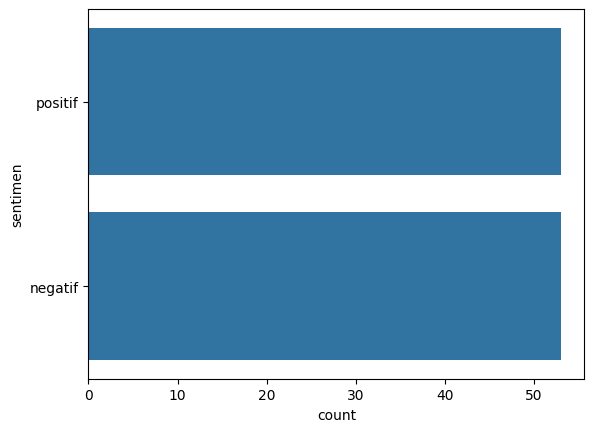

In [11]:
def balance_data(df, label_col):
    max_count = df[label_col].value_counts().max()
    balanced_df = pd.concat([
        resample(df[df[label_col] == cls], replace=True, n_samples=max_count, random_state=42)
        for cls in df[label_col].unique()
    ])
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

df = balance_data(df, 'sentimen')

import seaborn as sns
sns.countplot(df['sentimen'])

In [12]:
X = df['text']
y = df['sentimen']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print(X_train.shape[1])

440


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

MultinomialNB()

Akurasi: 0.91

Classification Report:
               precision    recall  f1-score   support

     negatif       0.85      1.00      0.92        11
     positif       1.00      0.82      0.90        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22



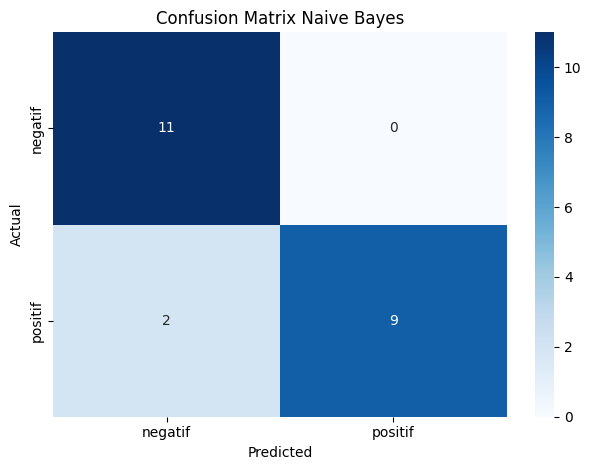

In [14]:
import matplotlib.pyplot as plt

y_pred = nb_model.predict(X_test)

akurasi = accuracy_score(y_test, y_pred)
print(f"Akurasi: {akurasi:.2f}")

try:
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
except:
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
try:
    labels = le.classes_
except:
    labels = sorted(list(set(y_test)))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Naive Bayes')
plt.tight_layout()
plt.show()

In [15]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_train.sum(axis=0).A1

top_words_df = pd.DataFrame({
    'Kata': feature_names,
    'Skor_TFIDF': tfidf_sum
}).sort_values(by='Skor_TFIDF', ascending=False)

print(top_words_df.head(20))

             Kata  Skor_TFIDF
149         jalan    6.870892
41           baik    3.521093
167         kalau    2.690040
229         lurah    2.623109
245    masyarakat    2.497984
98   denpasarkota    2.493462
185         kerja    2.466009
257           min    2.221511
191            kk    2.216358
337         rusak    2.100841
358        sekali    2.070980
421         tukad    2.060863
97       denpasar    2.036512
27          aspal    1.971556
419       trotoar    1.919782
364       selatan    1.801627
344          sana    1.759057
227        lubang    1.722038
196       koreksi    1.703189
339         salah    1.703189


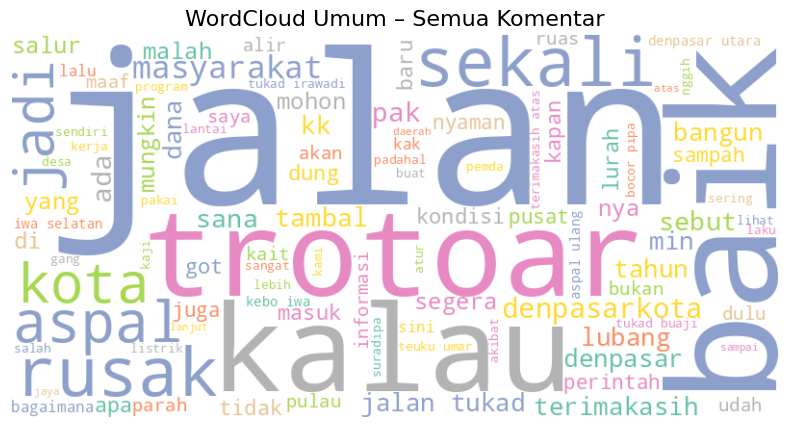

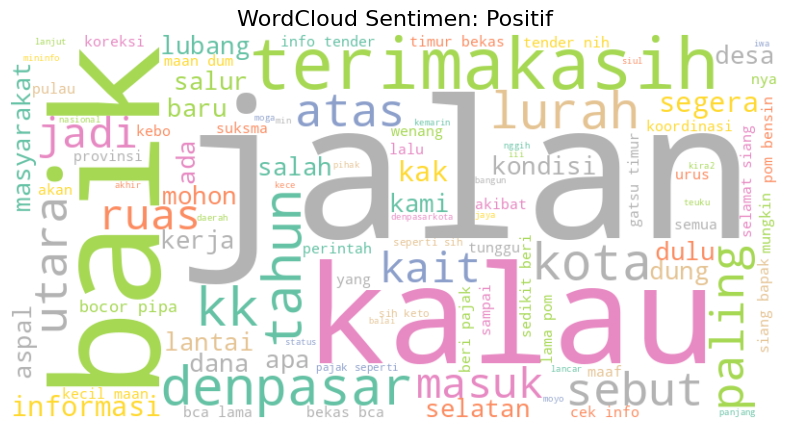

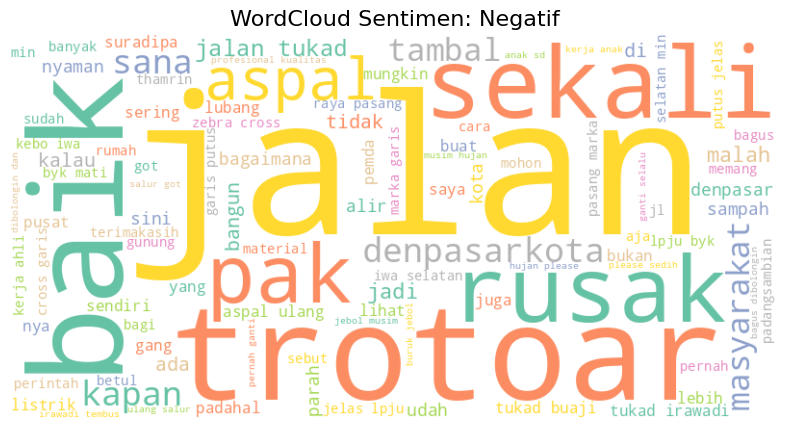

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Set2',
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

all_text = ' '.join(df['text'])
generate_wordcloud(all_text, "WordCloud Umum – Semua Komentar")

for label in df['sentimen'].unique():
    sentimen_text = ' '.join(df[df['sentimen'] == label]['text'])
    generate_wordcloud(sentimen_text, f"WordCloud Sentimen: {label.capitalize()}")

/tmp/ipython-input-536105647.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette='Set2')


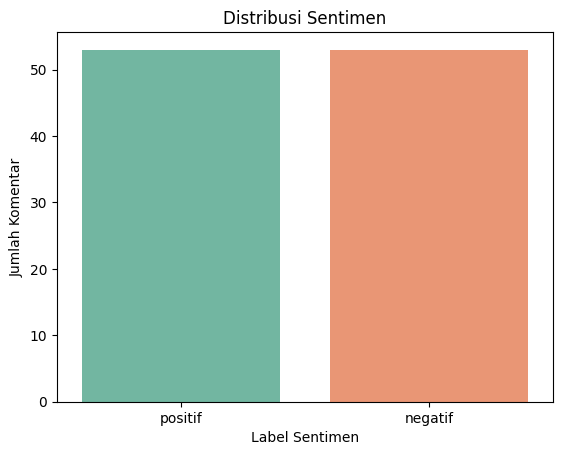

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sentimen_counts = df['sentimen'].value_counts()

sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette='Set2')
plt.title("Distribusi Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xlabel("Label Sentimen")
plt.show()

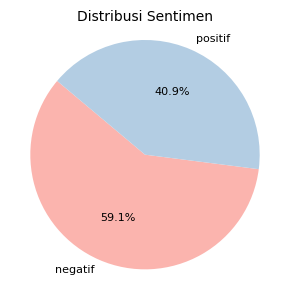

In [18]:
sentimen_count = Counter(y_pred)

labels = list(sentimen_count.keys())
jumlah = list(sentimen_count.values())
colors = ['lightcoral', 'gold', 'mediumseagreen']

plt.figure(figsize=(3, 3))
plt.pie(
    jumlah,
    labels=labels,
    colors=plt.cm.Pastel1.colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 8},
    radius=0.8
)
plt.title("Distribusi Sentimen", fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [19]:
emosi_lexicon = {
    "senang": [
        "terima kasih", "suksma", "mantap", "bagus", "baik", "puas", "makasih",
        "moga lancar", "nggih", "selamat", "hebat", "nyaman", "ideal", "makmur", "unggul"
    ],
    "sedih": [
        "sedih", "kecewa", "miris", "nyeri", "parah", "sayang", "capek", "buruk", "rusak",
        "banjir", "lubang", "bobol", "buntu", "kotor", "bahaya", "gelap", "begajulan", "tidak rata",
        "tidak nyaman", "tidak fungsi", "tidak profesional", "tidak bermanfaat", "kurang"
    ],
    "marah": [
        "ngapain", "aneh", "kenapa", "kok bisa", "gimana", "tidak tahu", "kenapa belum",
        "asal-asalan", "tidak sesuai", "salah", "tidak mempan", "komplain", "tidak adil", "jengkel"
    ],
    "optimis": [
        "optimis", "harap", "semoga", "astungkara", "yakin", "mudah-mudahan",
        "moga", "harap", "lanjut", "segera", "dalam tahap", "akan baik", "akan aspal",
        "akan diperbaiki", "masuk list", "masuk proyek", "teruskan", "ditindaklanjuti"
    ],
    "ragu-ragu": [
        "mungkin", "bingung", "gatau", "tidak tahu", "ragu", "entahlah", "kurang tahu",
        "belum pasti", "kayaknya", "seperti", "kalau", "kira-kira"
    ],
    "kritis": [
        "cek", "tolong", "kapan", "kenapa", "harap", "koordinasi", "perlu perhatian",
        "tolong atensi", "apakah", "harus", "bagaimana", "seharusnya", "kenapa tidak", "mohon"
    ]
}

def deteksi_emosi(teks):
    teks = str(teks).lower()
    for emosi, kata_kunci in emosi_lexicon.items():
        for kata in kata_kunci:
            if kata in teks:
                return emosi
    return "biasa saja"

df['emosi'] = df['text'].apply(deteksi_emosi)

df[['text', 'emosi']].head(10)

,text,emosi
0,nggih terimakasih atas masuk tanya mininfo sam...,senang
1,denpasarkota subak dung kering pak mohon alir ...,senang
2,denpasarkota mohon di tindak lanjut kalau di s...,sedih
3,moga lancar jaya lantai iii apa 3 lantai,senang
4,moga lancar jaya lantai iii apa 3 lantai,senang
5,sekar jepun nggih,senang
6,jalan raya pasang marka garis jalan zebra cros...,biasa saja
7,jalan suradipa peguyangan denpasar utara parah...,sedih
8,wenang balai jalan nasional kk,biasa saja
9,denpasarkota subak dung kering pak mohon alir ...,senang


In [20]:
print("Jumlah data emosi:")
print(df['emosi'].value_counts())

Jumlah data emosi:
emosi
senang        44
biasa saja    26
sedih         19
kritis         6
ragu-ragu      5
optimis        3
marah          3
Name: count, dtype: int64


In [21]:
def preprocess_input(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()

    for key, value in norm.items():
        text = text.replace(key, value)

    text = stop_remover.remove(text)
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def deteksi_emosi(teks):
    teks = str(teks).lower()
    for emosi, kata_kunci in emosi_lexicon.items():
        for kata in kata_kunci:
            if kata in teks:
                return emosi
    return "biasa saja"

def predict_sentiment(text):
    cleaned_text = preprocess_input(text)
    tfidf_vector = vectorizer.transform([cleaned_text])
    prediction = nb_model.predict(tfidf_vector)
    prediction_label = prediction[0]
    emosi = deteksi_emosi(text)
    return prediction_label, emosi

In [22]:
input_text = "Denpasar semakin bersih dan tertata."
hasil_sentimen, hasil_emosi = predict_sentiment(input_text)

print("Teks:", input_text)
print("Prediksi Sentimen:", hasil_sentimen)
print("Prediksi Emosi:", hasil_emosi)

Teks: Denpasar semakin bersih dan tertata.
Prediksi Sentimen: positif
Prediksi Emosi: biasa saja
